In [1]:
!pip install geocube

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.4/146.4 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 9.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import geopandas as gpd
from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_image
from functools import partial
from rasterio.enums import MergeAlg
from shapely.geometry import LineString
import matplotlib as plt
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt2
import rasterio as rio
import numpy as np
from scipy import stats
import geopandas as gpd
import requests
from io import BytesIO
from zipfile import ZipFile


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
url = 'https://github.com/IsamAljawarneh/datasets/raw/master/data/nyc1.zip'

response = requests.get(url)
if response.status_code == 200:
    with BytesIO(response.content) as file_bytes:
        with ZipFile(file_bytes) as zip_file:
            zip_names = zip_file.namelist()
            with zip_file.open(zip_names[0]) as file:
                Taxi_NYC = pd.read_csv(file)
                print(Taxi_NYC.head())
else:
    print("Failed to retrieve the file. Status code:", response.status_code)


   id  VendorID lpep_pickup_datetime Lpep_dropoff_datetime Store_and_fwd_flag  \
0   0         2  2016-01-01 00:29:24   2016-01-01 00:39:36                  N   
1   1         2  2016-01-01 00:19:39   2016-01-01 00:39:18                  N   
2   2         2  2016-01-01 00:19:33   2016-01-01 00:39:48                  N   
3   3         2  2016-01-01 00:22:12   2016-01-01 00:38:32                  N   
4   4         2  2016-01-01 00:24:01   2016-01-01 00:39:22                  N   

   RateCodeID  Pickup_longitude  Pickup_latitude  Dropoff_longitude  \
0           1        -73.928642        40.680611         -73.924278   
1           1        -73.952675        40.723175         -73.923920   
2           1        -73.971611        40.676105         -74.013161   
3           1        -73.989502        40.669579         -74.000648   
4           1        -73.964729        40.682854         -73.940720   

   Dropoff_latitude  ...  Fare_amount  Extra  MTA_tax  Tip_amount  \
0         40.6980

In [8]:
# Convert Long Lat into numeric type
Taxi_NYC['Pickup_longitude'] = pd.to_numeric(Taxi_NYC['Pickup_longitude'])
Taxi_NYC['Pickup_latitude'] = pd.to_numeric(Taxi_NYC['Pickup_latitude'])
Taxi_NYC['Dropoff_longitude'] = pd.to_numeric(Taxi_NYC['Dropoff_longitude'])
Taxi_NYC['Dropoff_latitude'] = pd.to_numeric(Taxi_NYC['Dropoff_latitude'])
print(Taxi_NYC)

              id  VendorID lpep_pickup_datetime Lpep_dropoff_datetime  \
0              0         2  2016-01-01 00:29:24   2016-01-01 00:39:36   
1              1         2  2016-01-01 00:19:39   2016-01-01 00:39:18   
2              2         2  2016-01-01 00:19:33   2016-01-01 00:39:48   
3              3         2  2016-01-01 00:22:12   2016-01-01 00:38:32   
4              4         2  2016-01-01 00:24:01   2016-01-01 00:39:22   
...          ...       ...                  ...                   ...   
1445280  1445280         2  2016-01-31 23:59:36   2016-02-01 00:07:53   
1445281  1445281         2  2016-01-31 23:26:06   2016-01-31 23:31:22   
1445282  1445282         2  2016-01-31 23:50:36   2016-01-31 23:56:19   
1445283  1445283         2  2016-01-31 23:57:47   2016-02-01 00:06:58   
1445284  1445284         2  2016-01-31 23:59:54   2016-02-01 00:07:06   

        Store_and_fwd_flag  RateCodeID  Pickup_longitude  Pickup_latitude  \
0                        N           1        

In [9]:
# List of columns to keep
columns_to_keep = ['Pickup_longitude', 'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude']
Taxi_NYC = Taxi_NYC[columns_to_keep]

print(Taxi_NYC)

         Pickup_longitude  Pickup_latitude  Dropoff_longitude  \
0              -73.928642        40.680611         -73.924278   
1              -73.952675        40.723175         -73.923920   
2              -73.971611        40.676105         -74.013161   
3              -73.989502        40.669579         -74.000648   
4              -73.964729        40.682854         -73.940720   
...                   ...              ...                ...   
1445280        -73.807716        40.700451         -73.768478   
1445281        -73.951408        40.714001         -73.941483   
1445282        -73.954842        40.730213         -73.944626   
1445283        -73.953491        40.817211         -73.977127   
1445284        -73.892578        40.747250         -73.910049   

         Dropoff_latitude  
0               40.698044  
1               40.761379  
2               40.646072  
3               40.689034  
4               40.663013  
...                   ...  
1445280         40.6980

In [10]:
# Convert Long Lat into Point Geometry

pickup_points = gpd.GeoDataFrame(geometry = gpd.points_from_xy(x=Taxi_NYC['Pickup_longitude'], y=Taxi_NYC['Pickup_latitude']))
dropoff_points = gpd.GeoDataFrame(geometry = gpd.points_from_xy(x=Taxi_NYC['Dropoff_longitude'], y=Taxi_NYC['Dropoff_latitude']))

print(pickup_points)
print(dropoff_points)


                           geometry
0        POINT (-73.92864 40.68061)
1        POINT (-73.95267 40.72318)
2        POINT (-73.97161 40.67611)
3        POINT (-73.98950 40.66958)
4        POINT (-73.96473 40.68285)
...                             ...
1445280  POINT (-73.80772 40.70045)
1445281  POINT (-73.95141 40.71400)
1445282  POINT (-73.95484 40.73021)
1445283  POINT (-73.95349 40.81721)
1445284  POINT (-73.89258 40.74725)

[1445285 rows x 1 columns]
                           geometry
0        POINT (-73.92428 40.69804)
1        POINT (-73.92392 40.76138)
2        POINT (-74.01316 40.64607)
3        POINT (-74.00065 40.68903)
4        POINT (-73.94072 40.66301)
...                             ...
1445280  POINT (-73.76848 40.69808)
1445281  POINT (-73.94148 40.72477)
1445282  POINT (-73.94463 40.72630)
1445283  POINT (-73.97713 40.77958)
1445284  POINT (-73.91005 40.77554)

[1445285 rows x 1 columns]


In [11]:
# prompt: concatenate the pickup_pointss and the dropoff_pointss

nyc_points = pd.concat([pickup_points, dropoff_points], ignore_index=True)
print(nyc_points)

                           geometry
0        POINT (-73.92864 40.68061)
1        POINT (-73.95267 40.72318)
2        POINT (-73.97161 40.67611)
3        POINT (-73.98950 40.66958)
4        POINT (-73.96473 40.68285)
...                             ...
2890565  POINT (-73.76848 40.69808)
2890566  POINT (-73.94148 40.72477)
2890567  POINT (-73.94463 40.72630)
2890568  POINT (-73.97713 40.77958)
2890569  POINT (-73.91005 40.77554)

[2890570 rows x 1 columns]


In [12]:
# prompt: i want the ten maximum and minimum values from x and y and display them

minimum_x = nyc_points.geometry.x.min()
maximum_x = nyc_points.geometry.x.max()
minimum_y = nyc_points.geometry.y.min()
maximum_y = nyc_points.geometry.y.max()

print("Minimum x:", minimum_x)
print("Maximum x:", maximum_x)
print("Minimum y:", minimum_y)
print("Maximum y:", maximum_y)

# Get the ten maximum and minimum values from x and y
max_x_values = nyc_points.geometry.x.nlargest(10)
min_x_values = nyc_points.geometry.x.nsmallest(10)
max_y_values = nyc_points.geometry.y.nlargest(10)
min_y_values = nyc_points.geometry.y.nsmallest(10)

# Display the maximum and minimum values
print("Maximum x values:", max_x_values, sep = "\n")
print("Minimum x values:", min_x_values, sep = "\n")
print("Maximum y values:", max_y_values, sep = "\n")
print("Minimum y values:", min_y_values, sep = "\n")


Minimum x: -115.18130493164062
Maximum x: 0.0
Minimum y: 0.0
Maximum y: 43.168006896972656
Maximum x values:
5239     0.0
6216     0.0
6424     0.0
7355     0.0
9219     0.0
10835    0.0
12381    0.0
12618    0.0
12888    0.0
13239    0.0
dtype: float64
Minimum x values:
1203026   -115.181305
2822033   -115.178856
1421710   -115.177605
1411369   -115.177559
1443756   -115.175995
2842901   -115.175560
2889042   -115.175484
1384820   -115.175385
2752958   -115.175354
2761383   -115.175308
dtype: float64
Maximum y values:
1219444    43.168007
2073455    42.694790
635770     42.694782
635904     42.694782
2081055    42.694782
2081189    42.694782
635820     42.694775
2081105    42.694775
1028932    42.324322
1028933    42.324322
dtype: float64
Minimum y values:
5239     0.0
6216     0.0
6424     0.0
7355     0.0
9219     0.0
10835    0.0
12381    0.0
12618    0.0
12888    0.0
13239    0.0
dtype: float64


In [13]:
print(nyc_points)

                           geometry
0        POINT (-73.92864 40.68061)
1        POINT (-73.95267 40.72318)
2        POINT (-73.97161 40.67611)
3        POINT (-73.98950 40.66958)
4        POINT (-73.96473 40.68285)
...                             ...
2890565  POINT (-73.76848 40.69808)
2890566  POINT (-73.94148 40.72477)
2890567  POINT (-73.94463 40.72630)
2890568  POINT (-73.97713 40.77958)
2890569  POINT (-73.91005 40.77554)

[2890570 rows x 1 columns]


In [14]:
def remove_outliers_zscore(geodataframe, threshold=3):
    # Extracting coordinates from geometry
    coords = np.array([(point.x, point.y) for point in geodataframe.geometry])

    # Calculating z-scores for both longitude and latitude
    z_scores_lon = np.abs(stats.zscore(coords[:, 0]))
    z_scores_lat = np.abs(stats.zscore(coords[:, 1]))

    # Find outliers for both longitude and latitude
    outliers = (z_scores_lon > threshold) | (z_scores_lat > threshold)

    # Remove outliers
    cleaned_geodataframe = geodataframe[~outliers].copy()
    return cleaned_geodataframe

In [15]:
nyc_points = remove_outliers_zscore(nyc_points)

In [16]:
# prompt: i want the ten maximum and minimum values from x and y and display them

minimum_x = nyc_points.geometry.x.min()
maximum_x = nyc_points.geometry.x.max()
minimum_y = nyc_points.geometry.y.min()
maximum_y = nyc_points.geometry.y.max()

print("Minimum x:", minimum_x)
print("Maximum x:", maximum_x)
print("Minimum y:", minimum_y)
print("Maximum y:", maximum_y)

# Get the ten maximum and minimum values from x and y
max_x_values = nyc_points.geometry.x.nlargest(10)
min_x_values = nyc_points.geometry.x.nsmallest(10)
max_y_values = nyc_points.geometry.y.nlargest(10)
min_y_values = nyc_points.geometry.y.nsmallest(10)

# Display the maximum and minimum values
print("Maximum x values:", max_x_values, sep = "\n")
print("Minimum x values:", min_x_values, sep = "\n")
print("Maximum y values:", max_y_values, sep = "\n")
print("Minimum y values:", min_y_values, sep = "\n")

Minimum x: -78.25851440429688
Maximum x: -70.14051818847656
Minimum y: 37.52218627929688
Maximum y: 43.168006896972656
Maximum x values:
1199026   -70.140518
343100    -71.070084
1788385   -71.070107
1028934   -71.070122
343067    -71.070152
1028932   -71.070175
2474219   -71.070175
1028935   -71.070183
1788185   -71.070183
1788352   -71.070183
dtype: float64
Minimum x values:
280751    -78.258514
1967689   -77.526421
2717555   -76.685287
1272270   -76.432892
2553028   -75.939247
1107743   -75.938301
2553031   -75.932281
1107746   -75.932205
1107744   -75.926674
1107747   -75.925430
dtype: float64
Maximum y values:
1219444    43.168007
2073455    42.694790
635770     42.694782
635904     42.694782
2081055    42.694782
2081189    42.694782
635820     42.694775
2081105    42.694775
1028932    42.324322
1028933    42.324322
dtype: float64
Minimum y values:
280751     37.522186
1272270    38.197365
2717555    38.633171
1568428    39.355820
123143     39.356133
2777886    39.374725
2767190 

In [17]:
print(nyc_points)

                           geometry
0        POINT (-73.92864 40.68061)
1        POINT (-73.95267 40.72318)
2        POINT (-73.97161 40.67611)
3        POINT (-73.98950 40.66958)
4        POINT (-73.96473 40.68285)
...                             ...
2890565  POINT (-73.76848 40.69808)
2890566  POINT (-73.94148 40.72477)
2890567  POINT (-73.94463 40.72630)
2890568  POINT (-73.97713 40.77958)
2890569  POINT (-73.91005 40.77554)

[2885598 rows x 1 columns]


In [18]:
nyc_points = remove_outliers_zscore(nyc_points, threshold = 9)

In [19]:
print(nyc_points)

                           geometry
0        POINT (-73.92864 40.68061)
1        POINT (-73.95267 40.72318)
2        POINT (-73.97161 40.67611)
3        POINT (-73.98950 40.66958)
4        POINT (-73.96473 40.68285)
...                             ...
2890565  POINT (-73.76848 40.69808)
2890566  POINT (-73.94148 40.72477)
2890567  POINT (-73.94463 40.72630)
2890568  POINT (-73.97713 40.77958)
2890569  POINT (-73.91005 40.77554)

[2885225 rows x 1 columns]


In [20]:
nyc_points = nyc_points.set_crs('EPSG:4326')
nyc_points = nyc_points.to_crs('EPSG:3857')
nyc_points['value'] = 1
nyc_points = nyc_points[nyc_points.is_valid]
nyc_points = nyc_points[~nyc_points.is_empty]

In [21]:
Taxi_NYC_raster = make_geocube(
        vector_data = nyc_points,
        measurements = ["value"],
        resolution = (-50, 50),
        rasterize_function=partial(rasterize_image, merge_alg=MergeAlg.add),
        fill = 0)

In [24]:
Taxi_NYC_raster.rio.to_raster(r'/content/drive/MyDrive/ds-project-raster-compare/datasets/Taxi_NYC3950.tiff')

In [26]:
landsat = rio.open("/content/drive/MyDrive/ds-project-raster-compare/datasets/Taxi_NYC3950.tiff")

In [27]:
# The CRS
landsat.crs

CRS.from_epsg(3857)

In [28]:
# The bounds
landsat.bounds

BoundingBox(left=-8278250.0, bottom=4904200.0, right=-8182750.0, top=5043100.0)

In [29]:
# The number of bands available
landsat.count

1

In [30]:
# The band numbers that are available
landsat.indexes

(1,)

In [31]:
# Number of pixels in the x and y directions
landsat.shape

(2778, 1910)

In [32]:
# The 6 parameters that map from pixel to real space
landsat.transform

Affine(50.0, 0.0, -8278250.0,
       0.0, -50.0, 5043100.0)

In [33]:
# All of the meta data
landsat.meta

{'driver': 'GTiff',
 'dtype': 'int64',
 'nodata': 0.0,
 'width': 1910,
 'height': 2778,
 'count': 1,
 'crs': CRS.from_epsg(3857),
 'transform': Affine(50.0, 0.0, -8278250.0,
        0.0, -50.0, 5043100.0)}

In [34]:
# This is just a numpy array
data = landsat.read(1)
data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

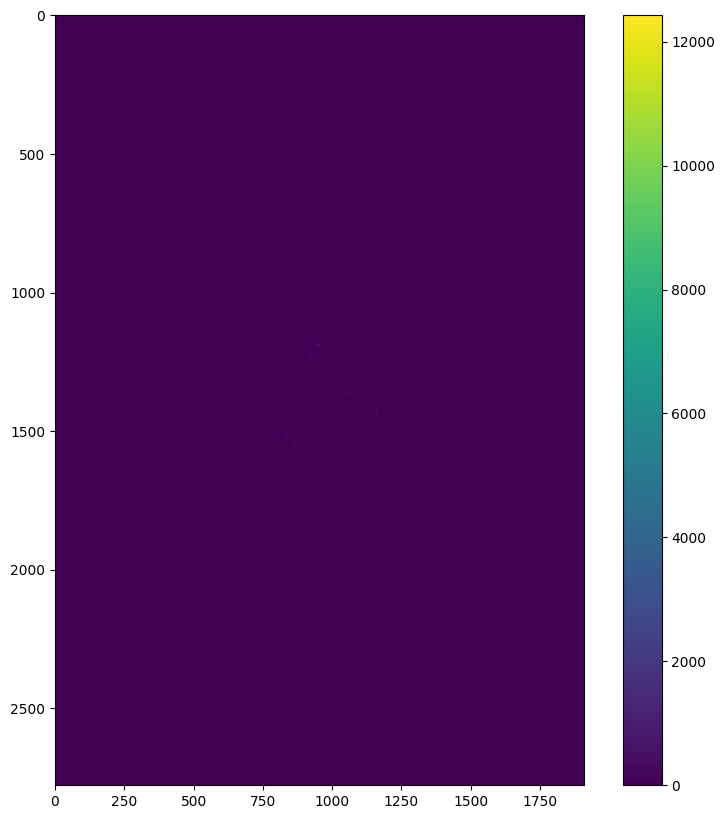

In [35]:
fig, ax = plt2.subplots(figsize=(10,10))

img = ax.imshow(data)

plt2.colorbar(img)

In [66]:

url = 'https://raw.githubusercontent.com/IsamAljawarneh/datasets/master/data/NYC_AQ.csv'

# Read the CSV file into a DataFrame
NYC_AQ = pd.read_csv(url)

# Display the first few rows of the DataFrame
print(NYC_AQ.head())

      SensorID        time   latitude  longitude  bin0  bin1  bin2  bin3  \
0  NYCP2_CS01A  1631277304  40.847672 -73.869316    11     1     1     0   
1  NYCP2_CS01A  1631277308  40.847668 -73.869316    22     4     1     0   
2  NYCP2_CS01A  1631277313  40.847649 -73.869362    40     1     1     0   
3  NYCP2_CS01A  1631277318  40.847649 -73.869362    26     1     0     0   
4  NYCP2_CS01A  1631277323  40.847649 -73.869362    44     4     0     1   

   bin4  bin5  ...  bin17  bin18  bin19  bin20  bin21  bin22  bin23  \
0     0     0  ...      0      0      0      0      0      0      0   
1     0     2  ...      0      0      0      0      0      0      0   
2     0     1  ...      0      0      0      0      0      0      0   
3     0     0  ...      0      0      0      0      0      0      0   
4     0     0  ...      0      0      0      0      0      0      0   

   temperature  humidity      pm25  
0         23.7      57.3  4.508813  
1         23.7      57.8  5.462420  
2    

In [67]:
# List of columns to keep
columns_to_keep = ['latitude', 'longitude', 'pm25']
NYC_AQ = NYC_AQ[columns_to_keep]

print(NYC_AQ)

         latitude  longitude      pm25
0       40.847672 -73.869316  4.508813
1       40.847668 -73.869316  5.462420
2       40.847649 -73.869362  5.154881
3       40.847649 -73.869362  4.508813
4       40.847649 -73.869362  5.539503
...           ...        ...       ...
169994  40.823353 -73.890488  5.460360
169995  40.823349 -73.890480  5.298209
169996  40.823349 -73.890480  6.470661
169997  40.823345 -73.890488  6.424142
169998  40.823338 -73.890488  6.526187

[169999 rows x 3 columns]


In [68]:
# Convert Long Lat into numeric type
NYC_AQ['longitude'] = pd.to_numeric(NYC_AQ['longitude'])
NYC_AQ['latitude'] = pd.to_numeric(NYC_AQ['latitude'])

In [69]:
AQ_points = gpd.GeoDataFrame(geometry = gpd.points_from_xy(x=NYC_AQ['longitude'], y=NYC_AQ['latitude']))

In [70]:
AQ_points = AQ_points.set_crs('EPSG:4326')
AQ_points = AQ_points.to_crs('EPSG:3857')
AQ_points['pm25'] = NYC_AQ['pm25']
AQ_points = AQ_points[AQ_points.is_valid]
AQ_points = AQ_points[~AQ_points.is_empty]
print(AQ_points)

                                geometry      pm25
0       POINT (-8223094.642 4989899.216)  4.508813
1       POINT (-8223094.642 4989898.627)  5.462420
2       POINT (-8223099.763 4989895.831)  5.154881
3       POINT (-8223099.763 4989895.831)  4.508813
4       POINT (-8223099.763 4989895.831)  5.539503
...                                  ...       ...
169994  POINT (-8225451.499 4986321.083)  5.460360
169995  POINT (-8225450.608 4986320.495)  5.298209
169996  POINT (-8225450.608 4986320.495)  6.470661
169997  POINT (-8225451.499 4986319.907)  6.424142
169998  POINT (-8225451.499 4986318.877)  6.526187

[169999 rows x 2 columns]


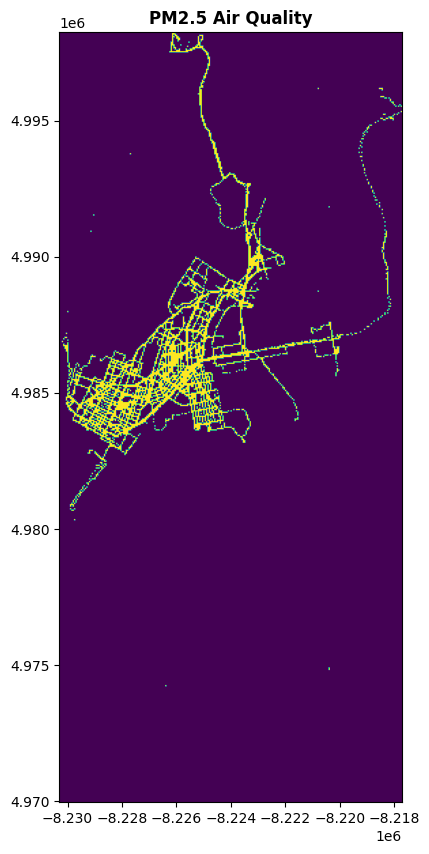

In [71]:
import geopandas as gpd
import rasterio
from rasterio.transform import from_origin
import matplotlib.pyplot as plt
from rasterio.plot import show

# Step 2: Rasterize the Data
# Define the bounds and resolution
bounds = AQ_points.total_bounds  # [minx, miny, maxx, maxy]
resolution = 50
width = int((bounds[2] - bounds[0]) / resolution)
height = int((bounds[3] - bounds[1]) / resolution)

# Create a transform
transform = from_origin(bounds[0], bounds[3], resolution, resolution)

# Create a raster array and fill it with a nodata value
pm25_raster = np.full((height, width), -9999, dtype='float32')

# Function to convert coordinates to raster indices
def coords_to_indices(x, y, transform):
    col, row = ~transform * (x, y)
    return int(row), int(col)

# Fill the raster array with PM2.5 values
for point, value in zip(AQ_points.geometry, AQ_points['pm25']):
    row, col = coords_to_indices(point.x, point.y, transform)
    if 0 <= row < height and 0 <= col < width:
        pm25_raster[row, col] = value

# Specify the path where you want to save the GeoTIFF
file_path = r'/content/drive/MyDrive/ds-project-raster-compare/datasets/AQ_NYC_raster.tiff'

# Create and write the GeoTIFF
with rasterio.open(
    file_path, 'w', driver='GTiff',
    height=pm25_raster.shape[0], width=pm25_raster.shape[1],
    count=1, dtype=pm25_raster.dtype,
    crs='+proj=latlong', transform=transform,
    nodata=-9999
) as dst:
    dst.write(pm25_raster, 1)

# Plotting the data
fig, ax = plt.subplots(figsize=(10, 10))
show(pm25_raster, transform=transform, ax=ax, cmap='viridis', title='PM2.5 Air Quality')
plt.show()


In [44]:
from google.colab import files
files.download("AQ_NYC_PM25.tiff")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
AQ_NYC_raster.rio.to_raster(r'/content/drive/MyDrive/ds-project-raster-compare/datasets/AQ_NYC_raster.tif')

In [21]:
AQ_NYC_raster = make_geocube(
    vector_data=AQ_points,
    measurements=["pm25"],  # Ensure this is the PM2.5 data
    resolution=(-50, 50),    # Make sure the resolution matches your needs
    rasterize_function=partial(rasterize_image, merge_alg=MergeAlg.add),
    fill=0                   # Handling nodata values
)

In [22]:
AQ_NYC_raster.rio.to_raster(r'/content/drive/MyDrive/ds-project-raster-compare/datasets/AQ_NYC_raster.tif')